In [10]:
# user defined functions
import odor_statistics_lib as osm
import classificationHelpers as chl

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
from hurst import compute_Hc, random_walk
from multiprocessing import Pool

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None


# %load_ext autoreload
# %autoreload 2

In [11]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

hws=pd.read_hdf(dir+'Windy/WindyMASigned.h5')
lws=(pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5'))
forest=(pd.read_hdf(dir+'Forest/ForestMASigned.h5'))

In [13]:
H,c,data=compute_Hc(lws.S2, kind='change',min_window = 100, max_window=None, simplified=False)
print(H)

0.9253103143951499


In [5]:
desert = pd.concat([hws,lws])
desert.reset_index(inplace=True, drop=True)

In [10]:
def get_time_col(df,dt):

    time = []
    time.append(0)
    for i in range(1,len(df)):
        time.append(time[i-1]+dt)
        
    return time

desert['sync_time'] = get_time_col(desert,desert.master_time[1]-desert.master_time[0])

### Using Hurst Library

In [34]:
H1,c1,data1=compute_Hc(hws.S2, kind='change',simplified=True)
H2,c2,data2=compute_Hc(lws.S2, kind='change',simplified=True)
H3,c3,data3=compute_Hc(forest.S2, kind='change',simplified=True)

# f, ax = plt.subplots()
# ax.plot(data[0], c*data[0]**H, color="deepskyblue")
# ax.scatter(data[0], data[1], color="purple")
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('Time interval')
# ax.set_ylabel('R/S ratio')
# ax.grid(True)
# plt.show()


print("HWS : H={:.4f}, c={:.4f}".format(H1,c1))
print("LWS: H={:.4f}, c={:.4f}".format(H2,c2))
print("Forest: H={:.4f}, c={:.4f}".format(H3,c3))

HWS : H=-0.9506, c=2884456630.3402
LWS: H=-0.7538, c=553202815.1878
Forest: H=-0.5911, c=66780174.3663


## Manual Calculation

In [24]:
def circular_deviation(angle, mean_angle):
    """Calculate the circular deviation of an angle from the mean angle."""
    deviation = angle - mean_angle
    while deviation > 180:
        deviation -= 360
    while deviation <= -180:
        deviation += 360
    return deviation

def calculate_RS_circular(series, n):
    """Calculate the rescaled range (R/S) for a given series and time span (n)"""
    subsets = np.array_split(series, len(series) // n)
    RS_values = []
    
    for subset in subsets:
        circular_mean = np.degrees(np.arctan2(np.mean(np.sin(np.radians(subset))), np.mean(np.cos(np.radians(subset)))))
        deviations = [circular_deviation(angle, circular_mean) for angle in subset]
        cumulative_deviation = np.cumsum(deviations)
        R = np.max(cumulative_deviation) - np.min(cumulative_deviation)
        
        # Compute the circular standard deviation
        R_avg = math.sqrt(np.mean(np.sin(np.radians(deviations)))**2 + np.mean(np.cos(np.radians(deviations)))**2)
        S = math.sqrt(-2 * math.log(R_avg))
        
        if S > 0:
            RS = R / S
            RS_values.append(RS)
    
    return np.mean(RS_values)

def calculate_RS(series, n):
    """Calculate the rescaled range (R/S) for a given series and time span (n)"""
    # Split the series into subsets of size n
    subsets = np.array_split(series, len(series) // n)
    
    RS_values = []
    
    for subset in subsets:
        mean = np.mean(subset)
        deviations = subset - mean
        cumulative_deviation = np.cumsum(deviations)
        R = np.max(cumulative_deviation) - np.min(cumulative_deviation)
        S = np.std(deviations)
        
        # Calculate the rescaled range (R/S) and add it to the list
        # If S is zero, skip this subset
        if S > 0:
            RS = R / S
            RS_values.append(RS)
    
    # Return the average R/S value for this value of n
    return np.mean(RS_values)

def worker(n,series):
    return calculate_RS(series, n)

def calculate_Hurst_exponent(series):
    # Specific lags for 1 second, 2 seconds, and 3 seconds
    n_values = [10,20, 30, 40, 80, 120]  # Given 40Hz sampling rate
    
    # Parallelize the R/S calculation
    with Pool() as pool:
        args = [(n, series) for n in n_values]
        RS_values = pool.starmap(worker, args)
    
    poly = np.polyfit(np.log10(n_values), np.log10(RS_values), 1)
    return poly[0]



# hurst_exponent = calculate_Hurst_exponent(hws.D[:100000])
# print('Hurst Exponent:', hurst_exponent)


(0.0, 10.0)

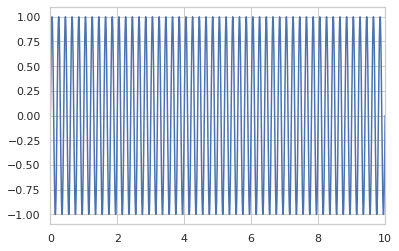

In [9]:
plt.plot(time,sine_wave)
plt.xlim(0,10)

In [8]:
amplitude = 1.0
frequency = 5 # in Hz
sampling_rate = 100000 # in Hz  
duration = 200.0 # in seconds

time = np.linspace(0, duration, int(sampling_rate * duration))
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

sine_wave = sine_wave[~np.isnan(sine_wave)]

# compute_Hc(sine_wave)[0]

H,c,data=compute_Hc(sine_wave, kind='change',min_window = 100, max_window=None, simplified=False)

In [9]:
H

0.4073871711479623

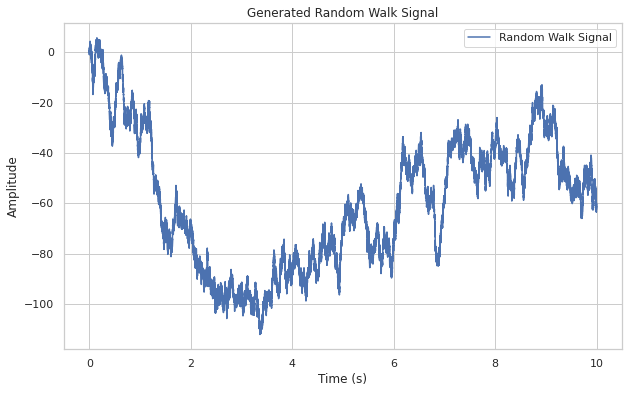

In [10]:
# Define parameters
sampling_rate = 100000  # in Hz
duration = 10.0  # in seconds

# Generate time values
time = np.linspace(0, duration, int(sampling_rate * duration))

# Generate random steps
num_steps = len(time)
random_steps = np.random.normal(0, 0.1, num_steps)  # Adjust the parameters as needed

# Generate the random walk signal
random_walk = np.cumsum(random_steps)

# Plot the random walk signal
plt.figure(figsize=(10, 6))
plt.plot(time, random_walk, label='Random Walk Signal')
plt.title('Generated Random Walk Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# calculate_Hurst_exponent(random_walk)
H1,c1,data1=compute_Hc(random_walk, kind='change',simplified=True)
print(H1)

0.5134016766680234


In [17]:
Speeds = [hws.S2, lws.S2, forest.S2]
Hspeed=[]
for i in range(len(Speeds)):
    Hspeed.append(calculate_Hurst_exponent(Speeds[i]))

In [18]:
Direction = [hws.D, lws.D, forest.D]
Hdir=[]
for i in range(len(Direction)):
    Hdir.append(calculate_Hurst_exponent(Direction[i]))

In [20]:
print(Hspeed)

[0.969999354996587, 0.9696726794028301, 0.9705743032272847]


In [21]:
print(Hdir)

[0.9641644040904762, 0.968484596931744, 0.9684754678177168]
